In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle

%matplotlib inline

In [8]:
from sidm_orbit_calculation.src.utils.constants import *
from sidm_orbit_calculation.src.plotting.make_plots import *

In [9]:
dpi=175
fontsize=9
pylab.rc('savefig', dpi=dpi)
pylab.rc('text', usetex=True)
pylab.rc('font', size=fontsize)
pylab.rc('xtick.major', pad=5)
pylab.rc('xtick.minor', pad=5)
pylab.rc('ytick.major', pad=5)
pylab.rc('ytick.minor', pad=5)

In [33]:
class Data:
    def __init__(self,fname):
        self.fname = fname
        self.times,self.positions,self.momenta,self.gravity,self.drag,self.density,self.host = self.read_data()
        # self.x0, self.y0, self.px0, self.py0 = self.initial_conditions()

    def read_data(self):
        fi = open(self.fname,'rb')
        data = cPickle.load(fi)
        fi.close()
        return data

    def initial_conditions(self):
        self.x0 = self.positions[0,0]
        self.y0 = self.positions[0,1]
        self.z0 = self.positions[0,2]
        self.px0 = self.momenta[0,0]
        self.py0 = self.momenta[0,1]
        self.pz0 = self.momenta[0,2]
        
    def compute_values(self):
        self.x = self.positions[:,0]
        self.y = self.positions[:,1]
        self.r = np.sqrt(self.x**2+self.y**2)
        self.phi = np.arctan2(self.y,self.x)
        self.px = self.momenta[:,0]
        self.py = self.momenta[:,1]
        self.momentum = np.sqrt(self.px**2+self.py**2)

In [28]:
data_path = '/Users/nora/sidm_orbit_calculation/src/output/'

In [36]:
fname = '1.0e+14_1.0e+12_1.0e+04_1.0e+10_leapfrog_spherical_NFW_0.dat'
data = Data(data_path + fname)
data.initial_conditions()
print 'Initial position = (%.3g, %.3g, %.3g) m' %(data.x0, data.y0, data.z0)
# print np.sqrt(data.x0**2 + data.y0**2 + data.z0**2)
print 'Initial velocity = (%.3g, %.3g, %.3g) m/s' %(data.px0, data.py0, data.pz0)
data.compute_values()

Initial position = (9.99e+21, -3.52e+20, 0) m
Initial velocity = (4.3e+04, 7.55e+05, 1.21e+06) m/s


In [20]:
def select_points(data,nmax=None):
    # select data to plot
    if not nmax: nmax = len(data.times)
    nn = len(data.times)
    dn = nn/nn
    tt = data.times[0:nmax:dn]
    xx = data.x[0:nmax:dn]/data.host.R_200
    yy = data.y[0:nmax:dn]/data.host.R_200
    vv = data.px[0:nmax:dn]
    return tt, xx, yy, vv

In [16]:
from scipy.special import expi

# ANALYTICAL CALCULATION WITHOUT DRAG
def analytical_velocity_nodrag(x):
    return np.sqrt(2*G*M*(1/x-1/x0))

# ANALYTICAL CALCULATION WITH DRAG
def analytical_velocity_drag(r):
    sigma = 1e4
    c1 = (-G * data.host.M * (data.host.rho * sigma * data.x0 * np.exp(data.host.rho * sigma * data.x0 / 2) * expi(-data.host.rho * sigma * data.x0 / 2) + 2)) / (data.x0 * np.exp(data.host.rho * sigma * data.x0 / 2))
    return np.sqrt(c1 * r * np.exp(data.host.rho * sigma * r / 2) + G * data.host.M * (data.host.rho * sigma * r * np.exp(data.host.rho * sigma * r / 2) * expi(-0.5 * data.host.rho * sigma * r) + 2)) / np.sqrt(r)

In [19]:
def check_velocity(data,drag=False):
    tt, xx, yy, vv = select_points(data,nmax=80000)
    if drag:
        vv_a = analytical_velocity_drag(xx[1:-1]*data.host.R_200)
    else:
        vv_a = analytical_velocity_nodrag(xx*data.host.R_200)

    print 'analytical: (%.5g, %.3g)' %(vv_a.min(),vv_a.max())
    print 'numerical: (%.5g, %.3g)' %(np.abs(vv).min(),np.abs(vv).max())
        
    pylab.figure(figsize=(3,3))
    pylab.plot(tt[1:-1],-vv[1:-1]/1e3,'g-',markersize=10,linewidth=2,label='numerical')
    # pylab.plot(tt2,-vv2/1e3,'r-',markersize=10,linewidth=2,label='no drag')
    pylab.plot(tt[1:-1],vv_a/1e3,'c--',markersize=10,linewidth=2,label='analytical')
    pylab.xlabel(r'$\mathrm{time\ (seconds)}$')
    pylab.ylabel(r'$\mathrm{velocity\ (km/s)}$')
    # pylab.xscale('log')
    pylab.yscale('log')
    pylab.legend(fontsize=8,loc='lower right') # fix formatting
    pylab.show()

In [ ]:
def drag_force():
    fig = plt.figure(figsize=(3,3))
    ax = plt.subplot(111)

    drag_magnitude = np.sqrt(data.drag[:,0]**2+data.drag[:,1]**2)
    ax.plot(xx,drag_magnitude[0:80000:nn/500], 'c', linewidth=2)
    # ax.plot(data.r[:-1]/data.host.R_200,drag_magnitude, 'c', linewidth=2)

    plt.xlabel(r'$\mathrm{Radius\ (r/R_{200})}$')
    plt.ylabel(r'$\mathrm{Effective\ Drag\ Force\ (m/s^2)}$')
    # plt.xscale('log')
    plt.yscale('log')
    
    fig = plt.figure(figsize=(3,3))
    ax = plt.subplot(111)

    ax.plot(-vv*m_to_kpc/seconds_to_years,drag_magnitude[0:80000:nn/500], 'c', linewidth=2)

    plt.xlabel(r'$\mathrm{Particle\ Velocity\ (kpc/yr)}$')
    plt.ylabel(r'$\mathrm{Effective\ Drag\ Force\ (m/s^2)}$')
    plt.xscale('log')
    plt.yscale('log')

    plt.show()

In [3]:
def radial_profile():
    return 

In [59]:
# this only works in x-y plane right now, is this ok?
def plot_orbit(data, xlim=None, ylim=None):
    fig = plt.figure(figsize=(3,3))
    ax = plt.subplot(111)

    plt.xlabel(r'$\mathrm{x/R_{200}}$')
    plt.ylabel(r'$\mathrm{y/R_{200}}$')
    # plt.xscale('log')
    # plt.yscale('log')
    
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    print 'Initial position = (%.3g, %.3g, %.3g) m' %(data[0].x0, data[0].y0, data[0].z0)
    print 'Initial velocity = (%.3g, %.3g, %.3g) m/s' %(data[0].px0, data[0].py0, data[0].pz0)
    
    for d in data:
        _, xx, yy, _ = select_points(d)
        ax.plot(xx,yy, linewidth=2)
        ax.plot(d.x0/d.host.R_200,d.y0/d.host.R_200,'k*',markersize=10)
    
    plt.show()    

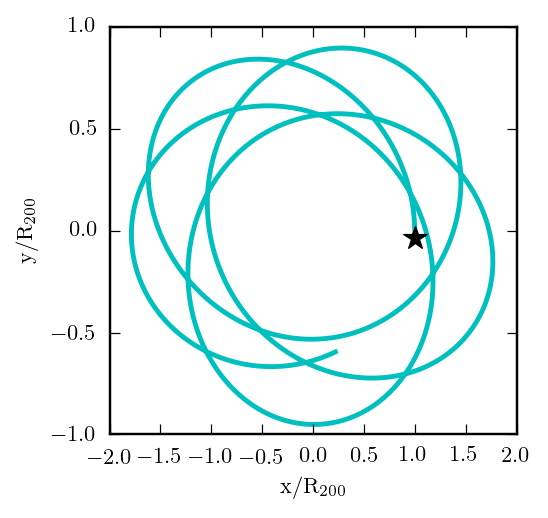

In [38]:
plot_orbit([data])

In [50]:
fname = '1.0e+14_1.0e+12_1.0e+04_1.0e+10_leapfrog_spherical_NFW_0.dat'
d1 = Data(data_path + fname)
d1.initial_conditions()
d1.compute_values()

fname = '1.0e+14_1.0e+12_1.0e+04_1.0e+10_dissipative_spherical_NFW_0.dat'
d2 = Data(data_path + fname)
d2.initial_conditions()
d2.compute_values()

data = [d1, d2]

Initial position = (9.99e+21, -3.52e+20, 0) m
Initial velocity = (4.3e+04, 7.55e+05, 1.21e+06) m/s


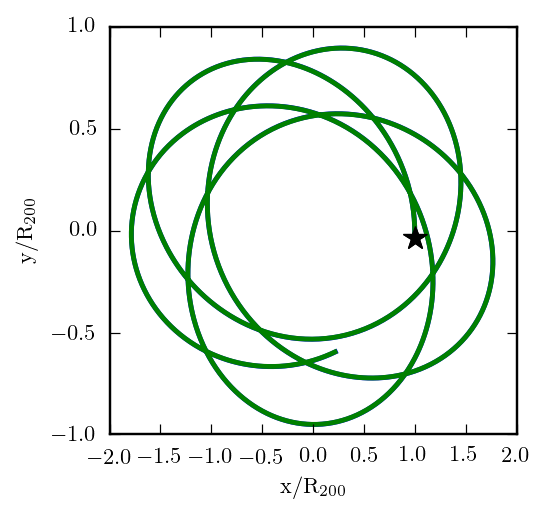

Initial position = (9.99e+21, -3.52e+20, 0) m
Initial velocity = (4.3e+04, 7.55e+05, 1.21e+06) m/s


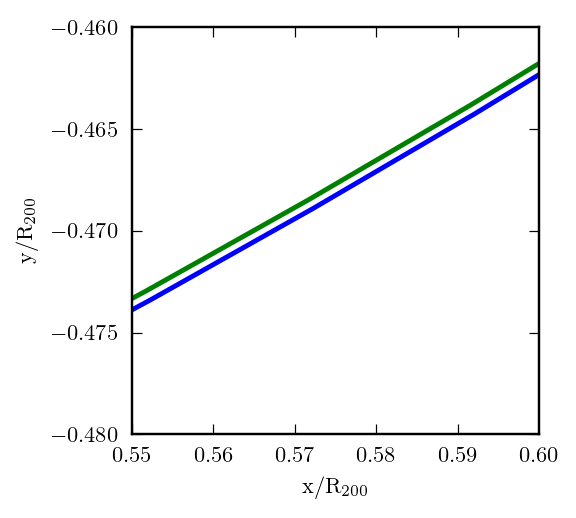

In [63]:
# plot_orbit([d1])
# plot_orbit([d2])
plot_orbit(data)
plot_orbit(data,[0.55,0.6],[-0.48,-0.46])

In [58]:
print '%.5g, %.5g' %(d1.x[-1], d1.y[-1])
print '%.5g, %.5g' %(d2.x[-1], d2.y[-1])

2.1917e+21, -5.9528e+21
2.1499e+21, -5.9559e+21


In [64]:
print d1.x.shape

(2001,)


In [68]:
print d1.x.nbytes/1e6*9

0.144072
